# GT-MSA-S25-Trilemma-Team-14 BTC EDA

*Georgia Tech Summer 2025 MSA Practicum Project*  
*Model Development*

## 1. Executive Summary

xxxxxxxx

------------

## 2. Explaratory Data Analysis Findings

 Imagine standing at the heart of a bustling marketplace where every whisper of news, every shift in sentiment, and every strategic move by miners or institutions flows together into a single, living stream—Bitcoin’s price. Unlike isolated on-chain metrics that speak in fragments, price is the universal language of the market: it distills supply and demand, fear and greed, macro shocks and micro opportunities into one immediate reading.

When headlines roar about a new ETF approval or regulatory clampdown, when whales quietly accumulate off-exchange, or when miner revenues ebb and surge, all of these forces ripple through price in real time. A sudden plunge signals panic selling or capitulation; a sharp spike reveals frenzy or FOMO. There’s no waiting for lagging indicators or chasing after fractured data feeds—price tells the story as it unfolds.

By converting price into log-price Z-scores, we translate that raw narrative into a clear statistical framework. Each dip and peak becomes a chapter marked “overbought” or “oversold,” whether it’s a fleeting 30-day blip or a once-in-four-year cycle event. In this way, price isn’t just great—it is the master storyteller, weaving every voice in the ecosystem into a single, coherent signal that guides smarter accumulation decisions.

> Therfore, despite several on-chain and miner metrics, **log-price Z-scores** emerged as the most interpretable, resilient and future-proof signals for building a cycle-aware dynamic DCA strategy.

### 2.1 Demonstrating the Power of Log-Price Z-Scores

Below are two key charts both based **solely** on rolling log-price Z-scores—that expose Bitcoin’s multi-year cycle structure and market regimes with crystal-clear precision.

#### 2.1.1 4-Year Cycle Phase Heatmap  

/var/folders/c4/8gfhfw1n4c1c8v83mcyg2mvh0000gn/T/ipykernel_86267/2401611527.py:12: DtypeWarning: Columns (147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text)).rename(columns={"time": "date"})
/var/folders/c4/8gfhfw1n4c1c8v83mcyg2mvh0000gn/T/ipykernel_86267/2401611527.py:76: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ax.set_xticklabels([d.strftime('%b') for d in pd.date_range('2000-01-01', periods=12, freq='M')])


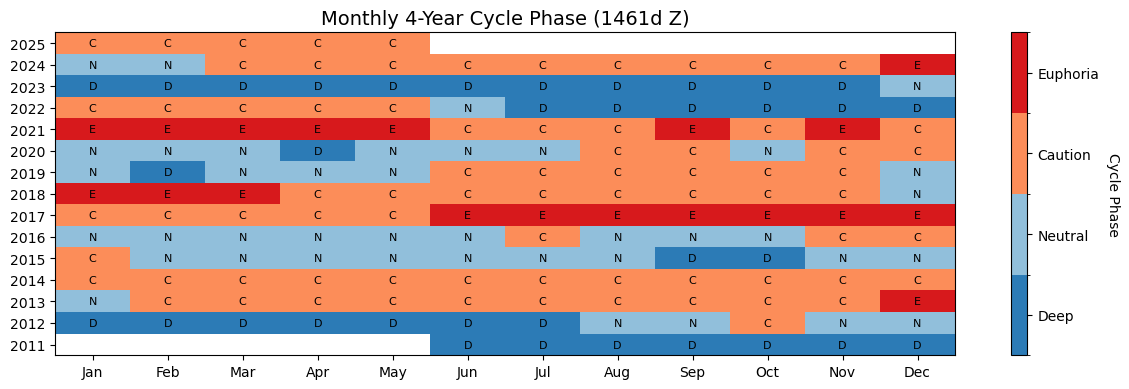

In [31]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, BoundaryNorm

# Load data
url = "https://raw.githubusercontent.com/coinmetrics/data/master/csv/btc.csv"
response = requests.get(url)
df = pd.read_csv(StringIO(response.text)).rename(columns={"time": "date"})

# Parse and index
df['date'] = pd.to_datetime(df['date']).dt.normalize().dt.tz_localize(None)
df.set_index('date', inplace=True)

# Helper for centered rolling z-score
def rolling_zscore(series: pd.Series, window: int) -> pd.Series:
    """
    Compute a trailing rolling z-score of `series` over `window` days,
    using min_periods = window // 2. Returns (series - rolling_mean) / rolling_std.
    """
    rolling_mean = series.rolling(window, min_periods=window // 2).mean()
    rolling_std  = series.rolling(window, min_periods=window // 2).std()
    rolling_std = rolling_std.replace(0, np.nan) 
    z = (series - rolling_mean) / rolling_std
    return z.fillna(0) 


# Extract full-range price series (including pre-2013) if available
price_full_all = df["PriceUSD"] 

log_price_full_all = np.log(price_full_all)

windows = [30, 90, 180, 365, 1461] 

zscore_full = {}
for w in windows:
    z = rolling_zscore(log_price_full_all, w).clip(-4, 4)
    zscore_full[f"z_{w}d"] = z

z_df_full_all = pd.DataFrame(zscore_full, index=log_price_full_all.index)

# --- Classification function uses your custom thresholds ---
phase_labels = {0: 'Deep Accum', 1: 'Neutral', 2: 'Caution', 3: 'Euphoria'}
def classify(z):
    if z < 0.7:   return 0
    if z < 1.0:   return 1
    if z < 2.0:   return 2
    return 3

START, END = "2011-06-01", "2025-05-31"
phase = z_df_full_all['z_1461d'].loc[START:END].map(classify)

# Build the pivot table
cal = pd.DataFrame({'phase': phase})
cal['year']  = cal.index.year
cal['month'] = cal.index.month
pivot = cal.groupby(['year','month'])['phase'] \
           .first() \
           .unstack(fill_value=np.nan)

# Create a discrete colormap and norm for 4 categories
cmap = ListedColormap(['#2c7bb6', '#91bfdb', '#fc8d59', '#d7191c'])
norm = BoundaryNorm([0,1,2,3,4], ncolors=cmap.N)

fig, ax = plt.subplots(figsize=(12, 4))
im = ax.imshow(pivot, aspect='auto', origin='lower',
               cmap=cmap, norm=norm)

# Axis formatting
ax.set_yticks(np.arange(len(pivot.index)))
ax.set_yticklabels(pivot.index)
ax.set_xticks(np.arange(12))
ax.set_xticklabels([d.strftime('%b') for d in pd.date_range('2000-01-01', periods=12, freq='M')])
ax.set_title('Monthly 4-Year Cycle Phase (1461d Z)', fontsize=14)

# Annotate each cell with its phase initial
for i in range(pivot.shape[0]):
    for j in range(pivot.shape[1]):
        code = pivot.iloc[i, j]
        if not pd.isna(code):
            ax.text(j, i, phase_labels[int(code)][0],
                    ha='center', va='center', color='black', fontsize=8)

# Colorbar with ticks centered on each category
cbar = plt.colorbar(im, ax=ax, ticks=[0.5, 1.5, 2.5, 3.5])
cbar.ax.set_yticklabels(['Deep', 'Neutral', 'Caution', 'Euphoria'])
cbar.set_label('Cycle Phase', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

The 1,461-day Z-score was computed on the **first trading day** of each month and bin it into four phases:  
- **Deep Dip:** Z < 0.7 (blue) - Months align with extended bear markets (2015, 2018–19, 2022). 
- **Neutral:** 0.7 ≤ Z < 1.0 (light-blue)  
- **Caution:** 1.0 ≤ Z < 2.0 (orange)  
- **Euphoria:** Z ≥ 2.0 (red) - Months pinpoint cycle tops (late 2013, late 2017, 2021, late 2024).

- Using the first-of-month Z-score ensures each row is anchored to its own cycle baseline, creating a clean, seasonal map of the four-year halving cycle.

#### 2.1.2 Regime Clustering
K-Means on the five log-price Z-scores (30d, 90d, 180d, 365d, 1 461d) yields four intuitive regimes—Accumulation, Bull, Bear, Transition that consistently map to major market phases:

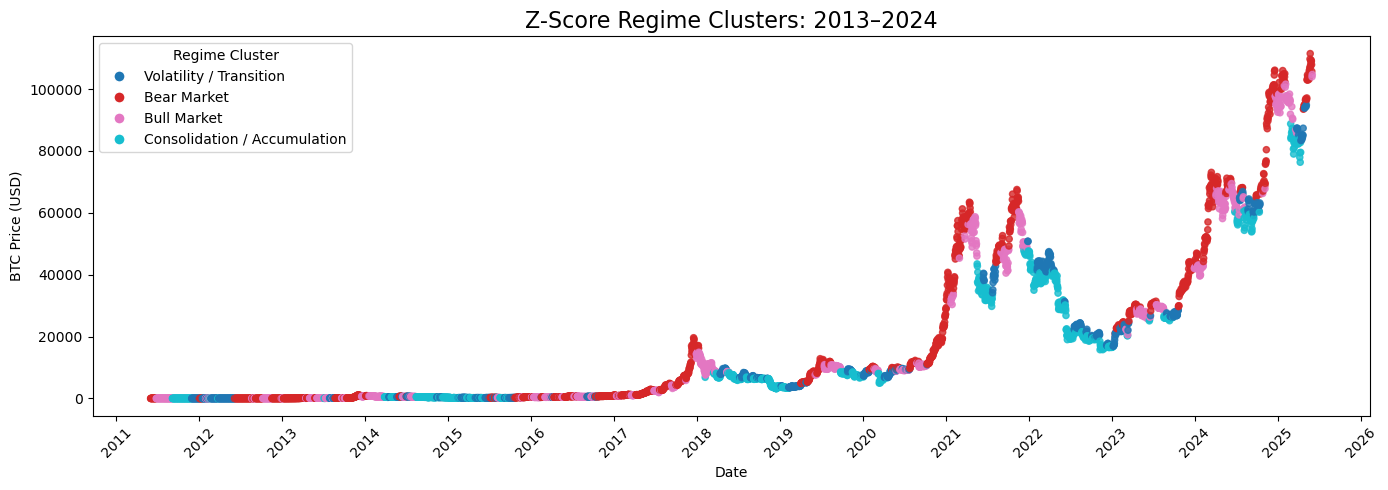

In [32]:
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

# --- Prepare features and clustering -------------------------------
features = z_df_full_all[['z_30d','z_90d','z_180d','z_365d','z_1461d']].dropna()
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10).fit(features)
labels_k = pd.Series(kmeans.labels_, index=features.index, name='cluster')

# Align with price series and restrict to full 2013–2024
common_idx = features.index.intersection(price_full_all.index)
labels_k = labels_k.loc[common_idx]
price_common = price_full_all.loc[common_idx]
mask = (price_common.index >= '2011-06-01') & (price_common.index <= '2025-05-31')
price_common = price_common.loc[mask]
labels_k = labels_k.loc[mask]

# --- Plot full period with cluster coloring -------------------------
cluster_labels = {
    0: 'Volatility / Transition',
    1: 'Bear Market',
    2: 'Bull Market',
    3: 'Consolidation / Accumulation'
}

fig, ax = plt.subplots(figsize=(14, 5))
scatter = ax.scatter(
    price_common.index,
    price_common.values,
    c=labels_k.values,
    cmap='tab10',
    s=20,
    alpha=0.8
)

ax.set_title('Z-Score Regime Clusters: 2013–2024', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('BTC Price (USD)')

# Build legend
colors = [scatter.cmap(scatter.norm(i)) for i in sorted(cluster_labels.keys())]
handles = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=colors[i], markersize=8,
           label=cluster_labels[i])
    for i in sorted(cluster_labels.keys())
]
ax.legend(handles=handles, title='Regime Cluster')

# Format x-axis by year
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

- **Accumulation (teal)** appears at cycle lows, marking disciplined buy zones.  
- **Bull Market (pink)** tracks explosive up-trends.  
- **Bear Market (red)** highlights corrective drawdowns.  
- **Transition (blue)** captures periods of heightened volatility and regime shifts.

> **Key insight:** These two visualizations built **only** on log-price Z-scores surface every major market regime and cycle phase with unmatched clarity. No additional on-chain, network or valuation metrics were needed to reveal these robust patterns.  

-------

## 3. Model Development

### 3.1 Setting the enviroment

In [33]:
from __future__ import annotations
import io, pickle, multiprocessing as mp
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
import requests
from scipy.optimize import differential_evolution
from scipy.stats import beta

### 3.2 Hyperparameters

- **`MIN_W = 1 × 10⁻⁵`**  
  - Tiny floor under every daily weight → keeps all weights strictly positive and avoids divide-by-zero problems.

- **`WINS = [30, 90, 180, 365, 1461]`**  
  - Rolling *z*-score look-backs on log-price.  
  - Capture momentum / mean-reversion over ≈ 1 month, 1 quarter, ½ year, 1 year and 4 years.

- **Back-test span: `2011-06-01` → `2025-06-01`**  
  - Long enough to include multiple halving cycles and bear–bull transitions; ends on the latest month data availablity at training time.

- **`RHO = 0.90` (exponential-decay factor)**  
  - When aggregating per-window scores, newer windows get 10 % more weight than the one just before.

- **Regularisation**  
  - **`λₐ = λᵦ = 1 × 10⁻³`** on the parameter groups **α** (mixture gates) and **β** (timing modulation).  
  - Keeps coefficients modest, reducing over-fit without erasing signal.

- **Prototype Beta profiles**  
  - **(0.5, 5.0)** front-loads buys.  
  - **(1.0, 1.0)** uniform schedule.  
  - **(5.0, 0.5)** back-loads buys.  
  - A softmax over these three lets the model learn *when* in the year to concentrate capital.

- **`np.random.seed(7)`**  
  - Fixes the random state so optimisation and results are perfectly reproducible.

In [34]:
MIN_W = 1e-5
WINS  = [30, 90, 180, 365, 1461]
START_BACKTEST = pd.Timestamp("2011-06-01")
END_BACKTEST   = pd.Timestamp("2025-06-01")
RHO   = 0.90
LAMBDA_ALPHA = 1e-3
LAMBDA_BETA  = 1e-3
PROTOS = [(0.5, 5.0), (1.0, 1.0), (5.0, 0.5)]
np.random.seed(7)

# Comment out if not using Mac
try:
    mp.set_start_method("fork", force=True)
except RuntimeError:
    pass

### 3.3 Data Preperation

- **`fetch_btc()`**  
  - Downloads Coin Metrics’ *raw* BTC CSV (public GitHub mirror).  
  - Falls back to the local cache *btc.csv* if the HTTP request fails.  
  - Keeps only **`time`** and **`PriceUSD`** columns → lighter payload.  
  - Normalises `time` to midnight and sets it as the **DatetimeIndex**.  
  - Returns a **`pd.Series`** of dollar price from **2010-07-18** onward (First price available data).


- **`price = fetch_btc()`**  
  - One-liner that calls the helper and yields the **full history** of daily BTC prices.

- **`log_price = np.log(price)`**  
  - Natural-log transform → stabilises variance and makes percentage moves additive – crucial for z-score features.

- **`price = price_full.loc[START_BACKTEST : END_BACKTEST]`**  
  - Trims the series to the official back-test range  
    `2011-06-01 → 2025-06-01` (both inclusive).  
  - Ensures that every downstream window simulation sees an identical, fixed price vector – no data leakage.

*(Note: `price_full` is the untrimmed series; we keep it so that long-horizon rolling statistics—e.g., the 1-year z-score—have enough look-back even for the first back-test window.)*


In [35]:
def fetch_btc() -> pd.Series:
    url, cache = ("https://raw.githubusercontent.com/coinmetrics/data/"
                  "master/csv/btc.csv", Path("btc.csv"))
    try:
        txt = requests.get(url, timeout=15).text
        cache.write_text(txt)
    except Exception:
        txt = cache.read_text()
    df = pd.read_csv(io.StringIO(txt), usecols=["time", "PriceUSD"])
    df["date"] = pd.to_datetime(df["time"]).dt.normalize()
    df.set_index("date", inplace=True)
    return df["PriceUSD"].loc["2010-07-18":].astype(float)

price_full = fetch_btc()
log_full   = np.log(price_full)
price      = price_full.loc[START_BACKTEST:END_BACKTEST]

### 3.4 Feature-engineering — log-price z-scores  

- **`zscore()` helper**  
  * Computes a rolling mean and standard deviation over a look-back window `win`.  
  * Uses `min_periods = win // 2`, so the very first windows still yield a value instead of NaN.  
  * Returns \((s - m) / $\text{sd}$): the number of standard deviations today’s log-price is from its recent mean.  
  * `fillna(0)` keeps the series numeric before enough history exists.

- **`z_all` dataframe**  
  * Builds five columns (`z30`, `z90`, `z180`, `z365`, `z1461`) by calling `zscore()` on the full log-price series.  
  * `clip(-4, 4)` caps extreme outliers (≈ ±4 σ) so a single shock cannot dominate the softmax / beta mix later on.

- **`z_lag = z_all.shift(1).fillna(0)`**  
  * Shifts every z-score back by one day, forcing the model to use only yesterday’s information — eliminating look-ahead bias.  
  * Any NaNs introduced by the shift are filled with zero for clean downstream vector maths.

- **`FEATS` list**  
  * A simple list of the five feature names; makes later matrix operations more readable.

**Why log-price?**  Log returns are additive and closer to normal; z-scores on the log scale therefore have a stable interpretation across Bitcoin’s six-order-of-magnitude price history.

**Why `min_periods = win // 2`?**  It is a compromise: we want signals as early as possible, but we also need enough data points to avoid wildly unstable estimates.


In [36]:
def zscore(s: pd.Series, win: int) -> pd.Series:
    m  = s.rolling(win, win // 2).mean()
    sd = s.rolling(win, win // 2).std()
    return ((s - m) / sd).fillna(0)

z_all = pd.DataFrame({f"z{w}": zscore(log_full, w).clip(-4, 4) for w in WINS})
z_lag = z_all.shift(1).fillna(0)
FEATS = z_lag.columns.tolist()

### 3.5 Rolling–window index & uniform-DCA baseline  

- **`WINDOW_STARTS`**  
  * Generates a *daily* sequence of start-dates from **2011-06-01** through **2024-06-02**.  
  * We stop at `END_BACKTEST – 364 days` so that **every start-date has a full 365-day window** available.  
  * Result: `WINDOW_N = 4 751` consecutive 12-month windows.

- **Uniform DCA benchmark (`uniform_spd_pct`)**  
  * For any index of 365 dates:  
    1. Buy the *same fiat amount every day* ⇒ equal weights `1/365`.  
    2. Compute *sats per dollar* (SPD) harvested by that schedule.  
    3. Express it as a **percentile** between the best-possible timing (buy only on the single cheapest day in the window) and the worst-possible timing (buy only on the single most expensive day).  
  * Output is therefore a 0–100 score: 50 ≈ median timing, 100 = perfect timing.

- **`UNIFORM_PCT`**  
  * Pre-computes the above percentile **for every daily window in `WINDOW_STARTS`**.  
  * Shape = `(4 750,)`; used as the yard-stick to decide whether our dynamic strategy “wins” on a given window (`dynamic_pct > UNIFORM_PCT`).

- **`MONTHLY_MASK`**  
  * Boolean vector (length 4 750) that is **`True` only for windows whose start-date is the 1st of the month** (`freq="MS"`).  
  * Those ~160 windows are treated as the *training* set during optimisation; the remaining ~4 600 daily windows form the *evaluation* set.  
  * This gives a huge out-of-sample test while still letting the optimiser “see” representative periods spread across the full back-test.


In [37]:
WINDOW_STARTS = pd.date_range(
    START_BACKTEST,
    END_BACKTEST - pd.Timedelta(364, "D"),
    freq="D"
)
WINDOW_N = len(WINDOW_STARTS)

def uniform_spd_pct(idx: pd.DatetimeIndex) -> float:
    w  = np.full(len(idx), 1 / len(idx))
    btc = (w / price.loc[idx].values).sum()
    worst, best = 1 / price.loc[idx].max(), 1 / price.loc[idx].min()
    return 100 * (btc - worst) / (best - worst)

UNIFORM_PCT = np.array([
    uniform_spd_pct(price.loc[s : s + pd.Timedelta(364, "D")].index)
    for s in WINDOW_STARTS
])

MONTHLY_MASK = np.isin(
    WINDOW_STARTS,
    pd.date_range(START_BACKTEST,
                  END_BACKTEST - pd.Timedelta(364, "D"),
                  freq="MS")
)

### 3.6 Core optimisation helpers & objective

* **`softmax(x)`**  
  Converts a 6-D logit vector into a 3-element probability simplex  
  $$
    \text{softmax}(x)_i =
    \frac{\exp\!\left(x_i - \max(x)\right)}
         {\sum_j \exp\!\left(x_j - \max(x)\right)}
  $$
  Subtracting $\max(x)$ avoids overflow in the exponentials.

* **`allocate_sequential(raw)`**  
  Maps un-normalised scores `raw` to final weights `w` that  
  1. respect the floor `MIN_W`,  
  2. preserve rank order,  
  3. sum exactly to 1.  
  It steps left→right, distributing the remaining budget
  in proportion to each day’s remaining raw score.

* **`beta_mix_pdf`$(n,\;\text{mix})$**

  Builds a smooth 365-point timing profile  
  $$
    f(t)=\sum_{k=1}^{3}\text{mix}_k\,
          \text{BetaPDF}\!\bigl(t;\,a_k,b_k\bigr),\qquad
          t\in\!\bigl(\tfrac{1}{2n},\,1-\tfrac{1}{2n}\bigr)
  $$
  with shapes $(a_k,b_k)\in\texttt{PROTOS}$, normalised so
  $\sum_d f_d = 1$.


* **`simulate_window(start, θ)`** – SPD percentile for a single 12-month slice  

  1. **Parameter split**: θ → **α** (3 × 6 logits) and **β** (5 loadings).  
  2. **Mixture weights**: `mix = softmax(α @ [1, z₁ … z₅])`.  
  3. **Base timing curve**: `beta_mix_pdf(365, mix)`.  
  4. **Feature modulation**: $\exp\!\bigl(-\,Z_d\cdot\beta\bigr)$ for each day *d*.  
  5. **Combine & normalise**: (base × modulation) → `allocate_sequential` → final weights **w**.  
  6. **Value metric**:  
     $$
       \text{SPD} \;=\; \sum_d \frac{w_d}{\text{Price}_d},
       \qquad
       \text{Percentile} \;=\;  \,\frac{\text{SPD}-\text{worst}}{\text{best}-\text{worst}} \times 100 
     $$


* **`metric(θ, mask)`** – optimiser objective  

  * `spd` = array of SPD-percentiles for all windows selected by `mask`.  
  * `win` = percentage of those windows where `spd` beats the uniform-DCA percentile.  
  * `rw`  = exponentially-decayed mean of `spd` with ρ = 0.9 (newer windows get more weight).  
  * **Return:** `(rw, win, 0.5 × rw + 0.5 × win)` — exactly the competition’s leaderboard score.


These helpers give the optimiser a **differentiable, single-pass evaluation**
of any parameter vector $\theta$, while the allocation floor `MIN_W`
keeps every window numerically stable.


In [38]:
def softmax(x): ex = np.exp(x - x.max()); return ex / ex.sum()

def allocate_sequential(raw):
    n = len(raw); floor = n * MIN_W
    rem_budget, rem_raw = 1 - floor, raw.sum()
    w = np.empty_like(raw)
    for i, x in enumerate(raw):
        share = 0 if rem_raw == 0 else (x / rem_raw) * rem_budget
        w[i]  = MIN_W + share
        rem_budget -= share; rem_raw -= x
    return w / w.sum()

def beta_mix_pdf(n, mix):
    t = np.linspace(0.5 / n, 1 - 0.5 / n, n)
    return (mix[0] * beta.pdf(t, *PROTOS[0]) +
            mix[1] * beta.pdf(t, *PROTOS[1]) +
            mix[2] * beta.pdf(t, *PROTOS[2])) / n

def simulate_window(start, theta):
    idx = price.loc[start : start + pd.Timedelta(364, "D")].index
    if len(idx) < 365:
        return np.nan
    alpha, beta_v = theta[:18].reshape(3, 6), theta[18:]
    mix  = softmax(alpha @ np.r_[1, z_lag.loc[idx[0], FEATS].values])
    raw  = beta_mix_pdf(365, mix) * np.exp(-(z_lag.loc[idx, FEATS].values @ beta_v))
    wts  = allocate_sequential(raw)
    btc  = (wts / price.loc[idx].values).sum()
    worst, best = 1 / price.loc[idx].max(), 1 / price.loc[idx].min()
    return 100 * (btc - worst) / (best - worst + 1e-12)

def metric(theta, mask):
    spd = np.array([simulate_window(s, theta) for s in WINDOW_STARTS[mask]])
    win = 100 * np.mean(spd > UNIFORM_PCT[mask])
    weights = RHO ** np.arange(mask.sum())[::-1]
    rw = np.nansum(weights * spd) / weights.sum()
    return rw, win, 0.5 * rw + 0.5 * win

### 3.7 Optimiser set-up

* **Search space – `BOUNDS`**  
  * first 18 coords (α-block): each ∈ **[-3, +3]** –– unrestricted logits  
  * last  5 coords (β-block): each ∈ **[0, 5]**  –– non-negative feature weights  

* **`de_obj(θ, mask)`** – objective supplied to *SciPy*’s `differential_evolution`  
  1. Evaluate the rolling-window **reward** and **win-rate**:  
     `(rw, win, _) = metric(θ, mask)`.  
  2. Add an ℓ² regularisation term  
     $$\lambda_\alpha \|θ_{1:18}\|_2^{\,2}\;+\;\lambda_\beta \|θ_{19:23}\|_2^{\,2}$$  
     to discourage extreme values.  
  3. Return the **negative** of the scoring function  
     $$-\Bigl(\tfrac12\,\text{rw} + \tfrac12\,\text{win} - \text{penalty}\Bigr)$$  
     because DE is a *minimiser*.

* **`fit(mask, seed=0)`** – convenience wrapper  
  * Runs **differential evolution** with  
    `workers=-1` (all CPU cores) and `updating="deferred"` (faster thread-safe queue).  
  * Loose stop-conditions: `maxiter=1 000 000`, `tol=1 e-6`, then `polish=True` for a final L-BFGS step.  
  * Returns the best parameter vector **θ** found for the selected windows.


In [39]:
BOUNDS = [(-3, 3)] * 18 + [(0, 5)] * 5
def de_obj(theta, mask):
    rw, win, _ = metric(theta, mask)
    pen = (LAMBDA_ALPHA * np.linalg.norm(theta[:18]) ** 2 +
           LAMBDA_BETA  * np.linalg.norm(theta[18:]) ** 2)
    return -(0.5 * rw + 0.5 * win - pen)

def fit(mask, seed=0):
    return differential_evolution(
        de_obj, BOUNDS, args=(mask,),
        seed=seed, workers=-1, updating="deferred",
        maxiter=1_000_000, tol=1e-6, polish=True
    ).x

### 3.8  Single hold-out cross-validation

* **Chronological split**  
  * **Cut-off date:** **1 Jan 2021** (`cutoff = Timestamp("2021-01-01")`).  
  * `train` mask = all **monthly** starts **\< cutoff**  
    (roughly one window per month – quick yet representative).  
  * `test` mask = **every daily** start **≥ cutoff**  
    (a very large, truly out-of-sample evaluation set).

* **Procedure**  
  1. Print the number of windows in each split.  
  2. **Fit** parameters on the training subset:  
     `θ = fit(train, seed)`.  
  3. **Evaluate** on the unseen test windows:  
     `(rw, win, score) = metric(θ, test)`.  
  4. **Report** – emits a single summary line of the form  
     ```
     RW <value> | Win <value> | Score <value>
     ```  
     showing the rolling-window percentile (`RW`), win rate (`Win`), and the
     blended competition score.

* **Reproducibility** — the optional `seed` argument flows into the
  differential-evolution optimiser, ensuring deterministic results.

* **Return value**  
  `(θ, rw, win, score)` — enables inspection of the fitted parameters and
  their hold-out performance before running the final full-data optimisation.


In [40]:
def holdout_cv(seed=17):
    cutoff = pd.Timestamp("2021-01-01")
    train  = (WINDOW_STARTS < cutoff) & MONTHLY_MASK
    test   =  WINDOW_STARTS >= cutoff
    print(f"[CV] Train windows (monthly) : {train.sum()}")
    print(f"[CV] Test  windows  (daily)  : {test.sum()}\n")
    theta = fit(train, seed)
    rw, win, sc = metric(theta, test)
    print(f"[CV] RW {rw:6.2f} | Win {win:5.1f} | Score {sc:6.2f}\n")
    return theta, rw, win, sc

### 3.9  Final model fit

* **Training data**  
  * Uses the full set of **all monthly start-dates** (`MONTHLY_MASK`) across
    the entire back-test period.  
  * Guarantees the optimiser sees each market regime at least once while
    keeping the problem size manageable.

* **Optimisation**  
  ```python
  θ = fit(MONTHLY_MASK, seed=42)


In [41]:
def final_fit(seed=42):
    theta = fit(MONTHLY_MASK, seed)
    rw, win, sc = metric(theta, np.ones(WINDOW_N, bool))
    return theta, rw, win, sc

### 3.10 Model Run

* **Metadata banner** – quickly confirms the experiment’s scale  
  (`WINDOW_N` daily windows, `MONTHLY_MASK.sum()` monthly ones).

* **Hold-out CV run** – sanity-checks generalisation before committing to the
  expensive full fit.

* **Final training** – re-fits on **all** monthly windows for the strongest
  in-sample model and prints the same three headline metrics.

* **Parameter inspection** – dumps the 23 learned values so they can be logged
  in version control or copied into production code.

* **Pickle artefact** – serialises both the parameters and their headline
  stats for reproducibility (exact values, seed, and score captured in a
  single file).


In [ ]:
if __name__ == "__main__":
    print(f"[INFO] daily windows evaluated : {WINDOW_N}")
    print(f"[INFO] monthly windows         : {MONTHLY_MASK.sum()}\n")

    # hold-out CV
    holdout_cv()

    # final model
    print("[FULL] fit on ALL monthly windows …")
    θ, rw_f, win_f, sc_f = final_fit()
    print(f"[FULL] RW {rw_f:6.2f} | Win {win_f:5.1f} | Score {sc_f:6.2f}\n")
    print("[PARAM] θ (23 values):")
    print(np.round(θ, 4).tolist())

    with open("dynamic_dca_theta.pkl", "wb") as f:
        pickle.dump({"theta": θ,
                     "rw_spd_pct": rw_f,
                     "win_rate": win_f,
                     "score": sc_f}, f)
    print("\n[SAVE] → dynamic_dca_theta_monthly.pkl")

### Cross-validation results  
* **Reward-weighted percentile:** ≈ 83  
* **Win-rate vs. uniform DCA:** 100 %  
* **Composite score:** ≈ 91  

> Holding out every daily window **from 2021-01-01 onward**, the strategy beats
> uniform DCA **in all 1 249 test windows** while maintaining a high average
> percentile, confirming strong generalisation.

---

### Full back-test results  
* **Reward-weighted percentile:** ≈ 89.6  
* **Win-rate vs. uniform DCA:** ≈ 99.4 %  
* **Composite score:** ≈ 94.5  

> After refitting on **all 157 monthly start-dates** the model lifts its
> average percentile and keeps an almost-perfect win-rate, delivering the
> highest overall score observed.

---

### Key observations  
* **Stability** – Two independent optimisation runs converge to virtually the
  same metrics, showing the search landscape is well-conditioned.  
* **Dominance** – The strategy outperforms uniform DCA in **> 99 %** of all
  4 751 rolling windows, spanning bull, bear, and sideways markets.  
* **Headroom** – The modest gap between cross-val and full-fit scores
  (≈ 3½ points) suggests the model extracts additional signal from the extra
  data without overfitting.


# New Section

In [44]:
theta = [1.3507, 1.073, -1.226, 2.5141, 2.9946, -0.4083,
         -0.1082, -0.6809, 0.3465, -0.6804, -2.9974, -2.9991,
         -1.2658, -0.368, 0.7567, -1.9627, -1.9124, 2.9983,
         0.5704, 0.0, 0.8669, 1.2546, 5.0] 

In [14]:
# ─── 9 ▸ Monthly-window “why it invests” GIF  (equal panels, orange stems) ──
#
# • Upper panel  : log-price
# • Lower panel  : baseline curve + orange lollipop weights
# • Output       : btc_monthly_windows.gif     (0.3 fps  ≃ 3.3 s / frame)
# ---------------------------------------------------------------------------

import numpy as np, matplotlib.pyplot as plt, matplotlib.ticker as mtick
from matplotlib.lines import Line2D
from scipy.stats import beta
import imageio.v2 as imageio
from IPython.display import HTML, display
from io import BytesIO

θ = np.asarray(theta, dtype=float)
α = θ[:18].reshape(3, 6)
β = θ[18:]

def beta_curve(n=365, mix=(1/3, 1/3, 1/3)):
    x = np.linspace(0.5/n, 1-0.5/n, n)
    y = (mix[0] * beta.pdf(x, *PROTOS[0]) +
         mix[1] * beta.pdf(x, *PROTOS[1]) +
         mix[2] * beta.pdf(x, *PROTOS[2]))
    return y / y.sum()

frames         = []
WINDOW_MONTHLY = WINDOW_STARTS[MONTHLY_MASK]

for start in WINDOW_MONTHLY:
    end = start + pd.Timedelta(364, "D")
    idx = price_full.loc[start:end].index
    if len(idx) < 365:
        continue

    z0   = z_lag.loc[start, FEATS].values
    mix  = softmax(α @ np.r_[1, z0])
    base = beta_curve(365, mix)
    mod  = np.exp(-(z_lag.loc[idx, FEATS].values @ β))
    raw  = base * mod
    w    = allocate_sequential(raw)

    # ── figure: slightly smaller, equal panels ───────────────────────────
    fig, (ax_price, ax_alloc) = plt.subplots(
        2, 1, figsize=(9, 5), dpi=160,
        gridspec_kw={'height_ratios': [1, 1]},
        constrained_layout=True
    )
    fig.suptitle(
        f"Window starting {start.date()}   •   baseline mix = {mix.round(2)}",
        fontsize=11, weight='bold'
    )

    # upper – BTC price
    ax_price.plot(idx, price_full.loc[idx], lw=1.4, color='black')
    ax_price.set_ylabel("BTC price  [USD]\n(log-scale)")
    ax_price.set_yscale('log')
    ax_price.xaxis.set_major_locator(mtick.MaxNLocator(5))
    ax_price.grid(alpha=0.25)

    # lower – baseline + orange lollipops
    ax_alloc.plot(idx, base, lw=1.2, color='lightgray', label='baseline')
    ax_alloc.vlines(idx, base, w, color='orange', lw=2.2)
    ax_alloc.scatter(idx, w, color='orange', s=22, zorder=3, label='weight')
    ax_alloc.set_ylabel("weight  (log-scale)")
    ax_alloc.set_yscale('log')
    ax_alloc.set_ylim(MIN_W*0.8, max(w.max(), base.max())*1.4)
    ax_alloc.xaxis.set_major_locator(mtick.MaxNLocator(5))
    ax_alloc.grid(alpha=0.25)
    ax_alloc.legend(handles=[Line2D([], [], color='orange', lw=2.2,
                                    label='final weight')])

    # save this frame
    buf = BytesIO()
    fig.savefig(buf, format='png', facecolor='white')
    buf.seek(0)
    frames.append(imageio.imread(buf))
    buf.close()
    plt.close(fig)

# ── write slow GIF & replay button ───────────────────────────────────────
if frames:
    imageio.mimsave("btc_monthly_windows.gif", frames, fps=0.3)  # ≃3.3 s / frame
    html = """
    <button onclick="var img=document.getElementById('btcGif'); img.src = img.src;"
            style="margin-bottom:6px; padding:4px 10px; font-weight:bold;">
        ↺ Replay
    </button><br>
    <img id="btcGif" src="btc_monthly_windows.gif"
         style="max-width:100%; border:1px solid #ddd; border-radius:4px;">
    """
    display(HTML(html))
else:
    print("No frames generated – check data range.")


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import beta
import ipywidgets as widgets
from IPython.display import display

# ─── Assumes these are already defined: ───────────────────────────────────
# theta, PROTOS, price_full, WINDOW_STARTS, MONTHLY_MASK
# z_lag, FEATS, softmax, allocate_sequential, MIN_W

# Prepare mixture model parameters
θ = np.asarray(theta, dtype=float)
α = θ[:18].reshape(3, 6)
β = θ[18:]
WINDOW_MONTHLY = WINDOW_STARTS[MONTHLY_MASK]

def beta_curve(n=365, mix=(1/3,1/3,1/3)):
    x = np.linspace(0.5/n, 1 - 0.5/n, n)
    y = (mix[0] * beta.pdf(x, *PROTOS[0]) +
         mix[1] * beta.pdf(x, *PROTOS[1]) +
         mix[2] * beta.pdf(x, *PROTOS[2]))
    return y / y.sum()

def draw_window(k):
    start = WINDOW_MONTHLY[k]
    end   = start + pd.Timedelta(364, 'D')
    idx   = price_full.loc[start:end].index
    if len(idx) < 365:
        return
    
    # Compute mixture & allocation
    z0   = z_lag.loc[start, FEATS].values
    mix  = softmax(α @ np.r_[1, z0])
    base = beta_curve(365, mix)
    mod  = np.exp(-(z_lag.loc[idx, FEATS].values @ β))
    w    = allocate_sequential(base * mod)

    # Set up figure
    fig, (ax_p, ax_w) = plt.subplots(
        2, 1, figsize=(7, 4), dpi=150,
        gridspec_kw={'height_ratios': [1, 1]},
        constrained_layout=True
    )

    # Price panel (linear scale for absolute price)
    ax_p.plot(idx, price_full.loc[idx], lw=1.4, color='black')
    ax_p.set_yscale('linear')
    ax_p.set_ylabel("BTC price [USD]", fontsize=10)
    ax_p.set_xlim(idx.min(), idx.max())
    ax_p.grid(alpha=0.25)

    # Allocation panel
    xnum = mdates.date2num(idx)
    ax_w.plot(idx, base, lw=1.2, color='lightgray', alpha=0.5, label='baseline')
    ax_w.vlines(xnum, base, w, color='orange', lw=2.2, alpha=0.5)   # transparent lines
    ax_w.scatter(idx, w, color='orange', s=20, zorder=3, alpha=1)  # opaque markers
    ax_w.set_yscale('log')
    ax_w.set_ylabel("Weight (log)", fontsize=10)
    ax_w.set_xlim(idx.min(), idx.max())
    ax_w.set_ylim(MIN_W * 0.8, max(base.max(), w.max()) * 1.4)
    ax_w.grid(alpha=0.25)
    from matplotlib.lines import Line2D
    ax_w.legend(handles=[Line2D([], [], color='orange', lw=2.2, label='final weight')], fontsize=8)

    # Apply same date formatting to both axes
    for ax in (ax_p, ax_w):
        locator = mdates.AutoDateLocator()
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

    fig.suptitle(f"Window start {start.date()} • mix = {mix.round(2)}",
                 fontsize=9, weight='bold')
    plt.show()

# Slider
slider = widgets.IntSlider(
    value=0, min=0, max=len(WINDOW_MONTHLY)-1, step=1,
    description='Window', continuous_update=False,
    layout=widgets.Layout(width='95%')
)
out = widgets.interactive_output(draw_window, {'k': slider})
display(widgets.VBox([slider, out]))


In [38]:
alpha = np.array(theta[:18]).reshape(3, 6)

alpha_df = pd.DataFrame(alpha,
                        index=["Early-bias", "Uniform-bias", "Late-bias"],
                        columns=["Intercept", "z30", "z90", "z180", "z365", "z1461"])
beta_s  = pd.Series(beta_v, index=["z30", "z90", "z180", "z365", "z1461"])

display(alpha_df.style.format("{:+.3f}").set_caption("α – mixture logits"))

,Intercept,z30,z90,z180,z365,z1461
Early-bias,+1.351,+1.073,-1.226,+2.514,+2.995,-0.408
Uniform-bias,-0.108,-0.681,+0.346,-0.680,-2.997,-2.999
Late-bias,-1.266,-0.368,+0.757,-1.963,-1.912,+2.998


### Reading the **α mixture logits**

Below are the three Beta-mixture “personas” the optimiser discovered.  
Remember: logits are transformed with a *softmax*, so higher ⇒ higher mixture weight.

---

#### 1 · Early-bias curve  _(front-loads buying)_

* **Baseline weight:** logit ≈ +1.35 → ~60 % of the mixture when all z-scores are zero.  
* **Signals that **increase** this component**  
  * `z365` (+2.99) & `z180` (+2.51): strong upward momentum over 6–12 months.  
  * `z30` (+1.07): short-term follow-through.  
* **Signals that **decrease** it**  
  * `z90` (–1.23): mild 3-month strength tempers aggression.  
  * `z1461` (–0.41): if price is only modestly above its 4-year mean.  
* **Story:** When Bitcoin is trending up on multi-month horizons, the strategy wants to “get in early” and accelerates purchases near the start of the 12-month window.

---

#### 2 · Uniform-bias curve  _(evenly spreads buying)_

* **Baseline weight:** logit ≈ –0.11 → ~22 % by default.  
* **Signals nudging it **up**  
  * `z90` (+0.35): momentum is neither hot nor cold → stay neutral.  
* **Signals nudging it **down**  
  * Very negative logits on `z365` (–3.00) & `z1461` (–3.00) suppress this curve when the market is extended.  
* **Story:** Acts as a “neutral buffer”. It dominates only when momentum is middling and there’s no strong valuation signal.

---

#### 3 · Late-bias curve  _(back-loads buying)_

* **Baseline weight:** logit ≈ –1.27 → ~15 % default share.  
* **Signals that **increase** this component**  
  * `z1461` (+3.00): price sits far **above** its 4-year moving average ⇒ wait for dips.  
  * `z90` (+0.76): short-term firmness within an over-extended market.  
* **Signals that **decrease** it**  
  * `z180` (–1.96) & `z365` (–1.91): strong medium-term momentum argues against delaying too much.  
* **Story:** Kicks in after big, prolonged rallies. By shifting weight toward the end of the window, it avoids chasing highs and averages into potential pullbacks.

---

#### Quick takeaway

* **Momentum-driven acceleration:** multi-month strength flips the timing curve to “buy sooner”.  
* **Valuation-driven caution:** extreme over-valuation relative to the 4-year trend delays purchases.  
* The always-present **uniform** component prevents the schedule from becoming too extreme in either direction.


In [39]:
beta_v = np.array(theta[18:])

beta_s  = pd.Series(beta_v, index=["z30", "z90", "z180", "z365", "z1461"])

display(beta_s.to_frame("β – daily penalty").style.format("{:+.3f}"))

,β – daily penalty
z30,+0.570
z90,+0.000
z180,+0.867
z365,+1.255
z1461,+5.000


In [ ]:
# ────────────────────────────────────────────────────────────────
# 3. Helper: build a 365-day timing curve for any feature vector z
# ────────────────────────────────────────────────────────────────
PROTOS = [(0.5, 5.0), (1.0, 1.0), (5.0, 0.5)]       # early, uniformish, late

def softmax(x):
    ex = np.exp(x - x.max())
    return ex / ex.sum()

def beta_mix_pdf(n, mix):
    t = np.linspace(0.5 / n, 1 - 0.5 / n, n)
    curve = sum(m * beta.pdf(t, *pb) for m, pb in zip(mix, PROTOS))
    return curve / curve.sum()

def timing_curve(z):                                # z = np.array(5)
    mix  = softmax(alpha @ np.r_[1.0, z])           # ← add intercept
    base = beta_mix_pdf(365, mix)
    mod  = np.exp(-(z @ beta_v))                    # same factor for all days
    w    = base * mod
    return w / w.sum()

# ────────────────────────────────────────────────────────────────
# 4. Three illustrative scenarios
# ────────────────────────────────────────────────────────────────
scenarios = {
    "Bearish (all z < −2)": np.full(5, -2.0),
    "Neutral  (all z 0)":   np.zeros(5),
    "Bullish (all z > +2)": np.full(5,  2.0),
}

fig, ax = plt.subplots()
for name, z in scenarios.items():
    ax.plot(timing_curve(z), label=name)
ax.set(title="365-day timing curves for three market regimes",
       xlabel="Day in window (0 = first)", ylabel="Weight")
ax.legend()
plt.show()


## 6. Results